# Collection of Data for Snowpack Layer Prediction and Analysis

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Stations, Daily

In [29]:
# Getting station data:
stations = Stations()
stations = stations.nearby(48.3680, 116.6227) # Coordinates of schwitzer
station = stations.fetch(1)
print(station.wmo[0])


44314


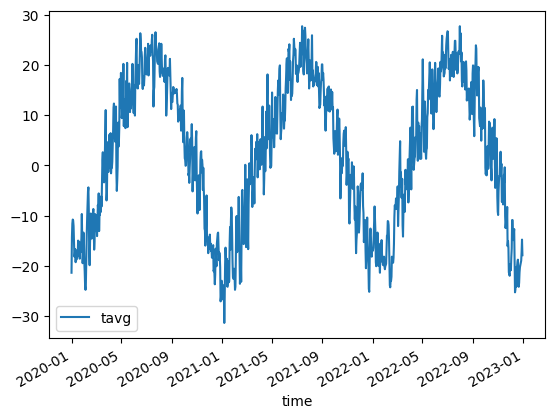

In [39]:
# Getting daily data:
start = datetime(2020, 1, 1)
end = datetime(2022, 12, 31)

daily_data = Daily(station.wmo[0], start, end)
daily_data = daily_data.fetch()

daily_data.plot(y=['tavg'])
plt.show()
